# Лабораторная работа №7

### 406 Кондратьев Егор


##### Задание:

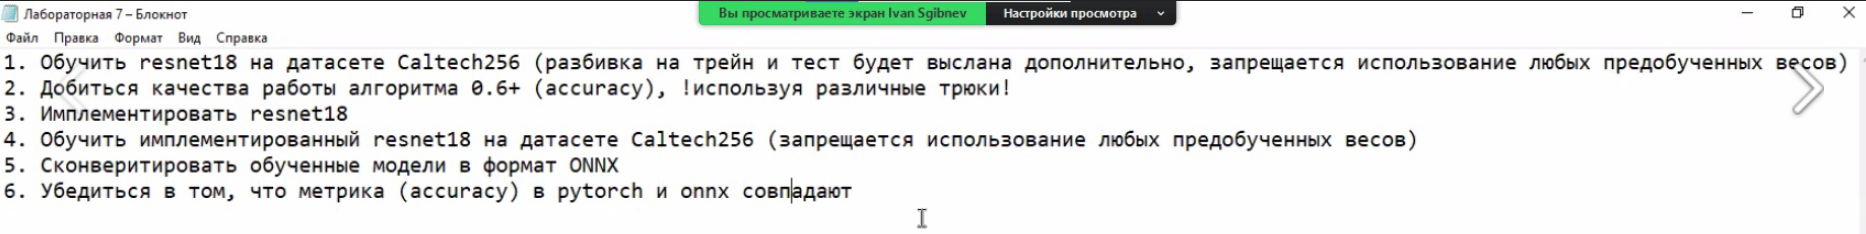

### Датасет Caltech256

In [52]:
data_dir = "/kaggle/input/caltech256/256_ObjectCategories"
save_path = "/kaggle/working/"

In [53]:
import torch
from torch.utils.data import Dataset, Subset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Кроме этого, мы выберем устройство, на котором будем работать
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device}')

cuda:0


Загрузим датасет и посмотрим на него

In [54]:
image_dataset = datasets.ImageFolder(data_dir)

In [55]:
def split_dataset(ds, split):
    train_idx, val_idx = train_test_split(list(range(len(ds))), test_size=split, stratify=ds.targets, random_state=42)
    train = Subset(ds, train_idx)
    val = Subset(ds, val_idx)
    return val, train

In [56]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=20, translate=(0.25, 0.25), shear=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'val': transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [57]:
val, train = split_dataset(ds=image_dataset, split=0.2)
val = DatasetFromSubset(val, transform = data_transforms['val'])
train = DatasetFromSubset(train, transform = data_transforms['train'])
image_datasets = {
    'val':  val,
    'train': train,
}

bs = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,
                                             shuffle=True, num_workers=1,)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_dataset.classes

{'train': 24485, 'val': 6122}


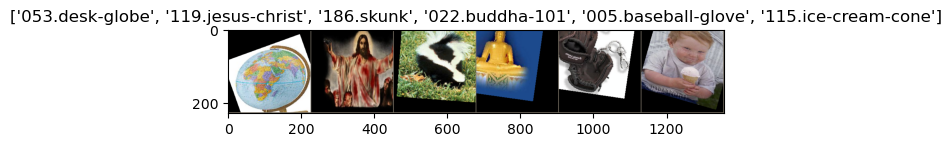

In [58]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean 

    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
inputs, classes = next(iter(dataloaders['train']))
inputs, classes = inputs[:6,], classes[:6, ]
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

---

### Функция обучения модели

In [59]:
!pip install torchtoolbox
from torchtoolbox.tools import mixup_data, mixup_criterion

In [60]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, name='resnet18', 
                early_patience=12, alpha=0.25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 99999999
    
    early_curr_patience = 0    
    stoped = False
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_image_count = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if phase == 'train':
                    inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, alpha)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
                    else:
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_image_count += preds.shape[0]
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                scheduler.step(epoch_loss)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val':
                if best_acc > epoch_acc:
                    early_curr_patience += 1
                else:
                    early_curr_patience = 0

                if early_curr_patience >= early_patience:
                    print('Ранняя остановка обучения')
                    stoped = True

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), f'{save_path}best_val_{name}.pt')
            if phase == 'train':
                torch.save(model.state_dict(), f'{save_path}train_{name}.pt')
            
        print()
        if stoped:
            break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    
    return model

In [61]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\ntarget: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

---

### Модель Resnet18

In [62]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.conv2.weight, mode='fan_in', nonlinearity='relu')

        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [63]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        nn.init.kaiming_normal_(self.conv1.weight, mode='fan_in', nonlinearity='relu')
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer3_drouput = nn.Dropout(p=0.25)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_dropout = nn.Dropout(p=0.25)
        self.fc = nn.Linear(512, num_classes)
        nn.init.xavier_normal_(self.fc.weight)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer3_drouput(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_dropout(x)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2)
        nn.init.kaiming_normal_(conv.weight, mode='fan_out', nonlinearity='relu')

        return nn.Sequential(
            conv,
            nn.BatchNorm2d(out_channels)
        )

In [64]:
model = ResNet_18(3, len(class_names)).to(device)

In [65]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,313,153 trainable parameters


In [66]:
сlass_count = [0] * len(class_names)
for el in image_dataset.targets:
    сlass_count[el]+=1
class_sum = len(image_dataset)
class_weights = torch.Tensor([class_sum/сlass_count[i] for i in range(len(class_names))])
class_weights = torch.nn.functional.normalize(class_weights, p=1, dim=0)

In [67]:
criterion = nn.CrossEntropyLoss(weight = class_weights).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=0.0001)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [68]:
model = train_model(model, criterion, optimizer,lr_scheduler, num_epochs=80)

Epoch 0/79
----------
train Loss: 5.5343 Acc: 0.0119
val Loss: 5.0536 Acc: 0.0470

Epoch 1/79
----------
train Loss: 5.1468 Acc: 0.0249
val Loss: 4.8742 Acc: 0.0769

Epoch 2/79
----------
train Loss: 4.9438 Acc: 0.0397
val Loss: 4.6563 Acc: 0.0944

Epoch 3/79
----------
train Loss: 4.8117 Acc: 0.0511
val Loss: 4.5400 Acc: 0.1248

Epoch 4/79
----------
train Loss: 4.6672 Acc: 0.0615
val Loss: 4.4216 Acc: 0.1411

Epoch 5/79
----------
train Loss: 4.5485 Acc: 0.0733
val Loss: 4.2918 Acc: 0.1617

Epoch 6/79
----------
train Loss: 4.4478 Acc: 0.0841
val Loss: 4.1603 Acc: 0.1820

Epoch 7/79
----------
train Loss: 4.3043 Acc: 0.0879
val Loss: 4.0255 Acc: 0.1941

Epoch 8/79
----------
train Loss: 4.2058 Acc: 0.0952
val Loss: 3.8438 Acc: 0.2225

Epoch 9/79
----------
train Loss: 4.1006 Acc: 0.1096
val Loss: 4.1678 Acc: 0.2035

Epoch 10/79
----------
train Loss: 3.9419 Acc: 0.1255
val Loss: 3.7219 Acc: 0.2450

Epoch 11/79
----------
train Loss: 3.9087 Acc: 0.1223
val Loss: 3.6294 Acc: 0.2747

Ep

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d637def4ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


train Loss: 2.6154 Acc: 0.2896
val Loss: 2.5132 Acc: 0.4566

Epoch 31/79
----------
train Loss: 2.6030 Acc: 0.2698
val Loss: 2.4133 Acc: 0.4850

Epoch 32/79
----------
train Loss: 2.5264 Acc: 0.2807
val Loss: 2.5101 Acc: 0.4543

Epoch 33/79
----------
train Loss: 2.4766 Acc: 0.2873
val Loss: 2.3006 Acc: 0.5020

Epoch 34/79
----------
train Loss: 2.4909 Acc: 0.2760
val Loss: 2.3086 Acc: 0.5067

Epoch 35/79
----------
train Loss: 2.4586 Acc: 0.2747
val Loss: 2.4601 Acc: 0.4820

Epoch 36/79
----------
train Loss: 2.4188 Acc: 0.3010
val Loss: 2.3996 Acc: 0.4900

Epoch 37/79
----------
train Loss: 2.3512 Acc: 0.2784
val Loss: 2.2767 Acc: 0.5162

Epoch 38/79
----------
train Loss: 2.2785 Acc: 0.2922
val Loss: 2.3519 Acc: 0.5000

Epoch 39/79
----------
train Loss: 2.3310 Acc: 0.3039
val Loss: 2.3491 Acc: 0.5025

Epoch 40/79
----------
train Loss: 2.2306 Acc: 0.3075
val Loss: 2.2471 Acc: 0.5175

Epoch 41/79
----------
train Loss: 2.1737 Acc: 0.3113
val Loss: 2.2912 Acc: 0.5150

Epoch 42/79
---

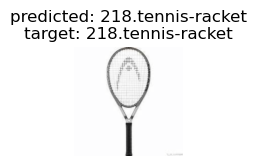

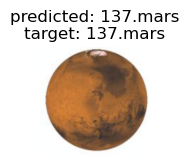

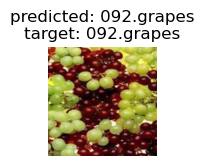

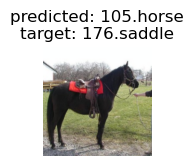

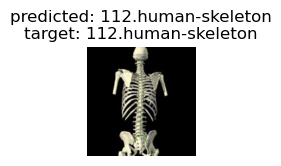

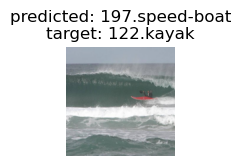

In [69]:
visualize_model(model)

plt.ioff()
plt.show()

In [70]:
def get_preds_from_dataloader(model, dataloader):
    was_training = model.training
    model.eval()
    y = []
    pred = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y.extend(labels.tolist())
            pred.extend(preds.tolist())
            
    model.train(mode=was_training)
    return y, pred # y - labels, pred - model

In [71]:
y_torch, pred_torch = get_preds_from_dataloader(model, dataloaders['val'])
print(classification_report(y_torch, pred_torch, target_names = class_names))

                               precision    recall  f1-score   support

                     001.ak47       0.74      0.70      0.72        20
            002.american-flag       0.59      0.89      0.71        19
                 003.backpack       0.91      0.67      0.77        30
             004.baseball-bat       0.29      0.48      0.36        25
           005.baseball-glove       0.81      0.83      0.82        30
          006.basketball-hoop       0.59      0.56      0.57        18
                      007.bat       0.67      0.29      0.40        21
                  008.bathtub       0.51      0.53      0.52        47
                     009.bear       0.50      0.65      0.57        20
                 010.beer-mug       0.81      0.68      0.74        19
                011.billiards       0.74      0.80      0.77        56
               012.binoculars       0.73      0.77      0.75        43
                 013.birdbath       0.59      0.50      0.54        20
     

---

### Экспортируем модель в ONNX формат

In [72]:
import torch.onnx

# Input to the model
x = torch.randn(1, 3, 224, 224, requires_grad=True).to(device)
torch_out = model(x)

# Export the model
onnx_resnet_path = f"{save_path}/resnet.onnx"
torch.onnx.export(model,
          x,
          onnx_resnet_path,
          export_params=True,
          opset_version=10,
          do_constant_folding=True,
          input_names = ['input'],
          output_names = ['output'],
          dynamic_axes={'input' : {0 : 'batch_size'},
                        'output' : {0 : 'batch_size'}})


In [73]:
!pip install onnxruntime
import onnxruntime as ort
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 60.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00


In [74]:
def calc_onnx_preds(onnx_model_path, dataloader):
    ort_sess = ort.InferenceSession(onnx_model_path)
    
    y = []
    pred = []
    
    for i, (inputs, labels) in enumerate(dataloader):
        outputs = ort_sess.run(None, {'input': inputs.numpy()})
        predicted = outputs[0].argmax(1)
        y.extend(labels.tolist())
        pred.extend(predicted)
        
    return y, pred

In [75]:
y_onnx, pred_onnx = calc_onnx_preds(onnx_resnet_path, dataloaders['val'])
acc_onnx = accuracy_score(y_onnx, pred_onnx)
acc_torch = accuracy_score(y_torch, pred_torch)

print(f'onnx acc: {acc_onnx:.6f} | torch acc: {acc_torch:.6f}')

onnx acc: 0.606991 | torch acc: 0.606991
